In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

# Clean the data

In [3]:
df = pd.read_csv("../data/WineQT.csv")

In [10]:
df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1138                 29.0                  40.0  0.99574  3.42       0.75   
1139                 28.0                  38.0  0.99651  3.42       0.82   
1140                 32.0                  44.0  0.99490  3.45       0.58   
1141                 39.0                  51.0  0.99512  3.52       0.76   
1142                 32.0                  44.0  0.99547  3.57       0.71   

      alcohol  quality    Id  
0         9.4        5     0  
1         9.8        5     1  
2         9.8        5     2  
3         9.8        6     3  
4         9.4        5     4  
...       ...      ...   ...  
1138     11.0        6  1592  
1139      9.5        6  1593  
1140     10.5        5  1594  
1141     11.2        6  1595  
1142     10.2        5  1597  

[1143 rows x 13 columns]

In [14]:
# Check NaNs
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

# EDA (Exploratory Data Analysis)

In [5]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             21.000000     0.995570   
50%       0.079000            13.000000             37.000000     0.996680   
75%       0.090000            21.000000             61.000000     0.997845   
max       0.611000            68.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality           Id  
count  1143.000000  1143.000000  1143.000000  1143.000000  1143.000000  
mean      3.311015     0.657708    10.442111     5.657043   804.969379  
std       0.156664     0.170399     1.082196     0.805824   463.997116  
min       2.740000     0.330000     8.400000     3.000000     0.000000  
25%       3.205000     0.550000     9.500000     5.000000   411.000000  
50%       3.310000     0.620000    10.200000     6.000000   794.000000  
75%       3.400000     0.730000    11.100000     6.000000  1209.500000  
max       4.010000     2.000000    14.900000     8.000000  1597.000000

<Axes: >

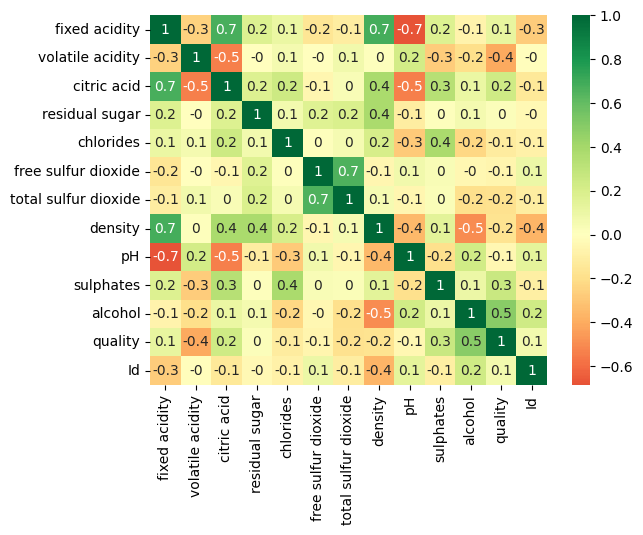

In [7]:
sns.heatmap(data=df.corr(), cmap='RdYlGn', center=0, annot=np.round(df.corr(), 1))

<Axes: >

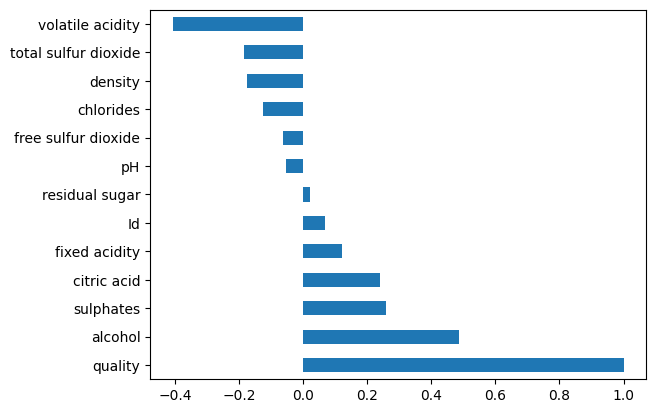

In [25]:
df.corr()['quality'].sort_values(ascending=False).plot(kind="barh")

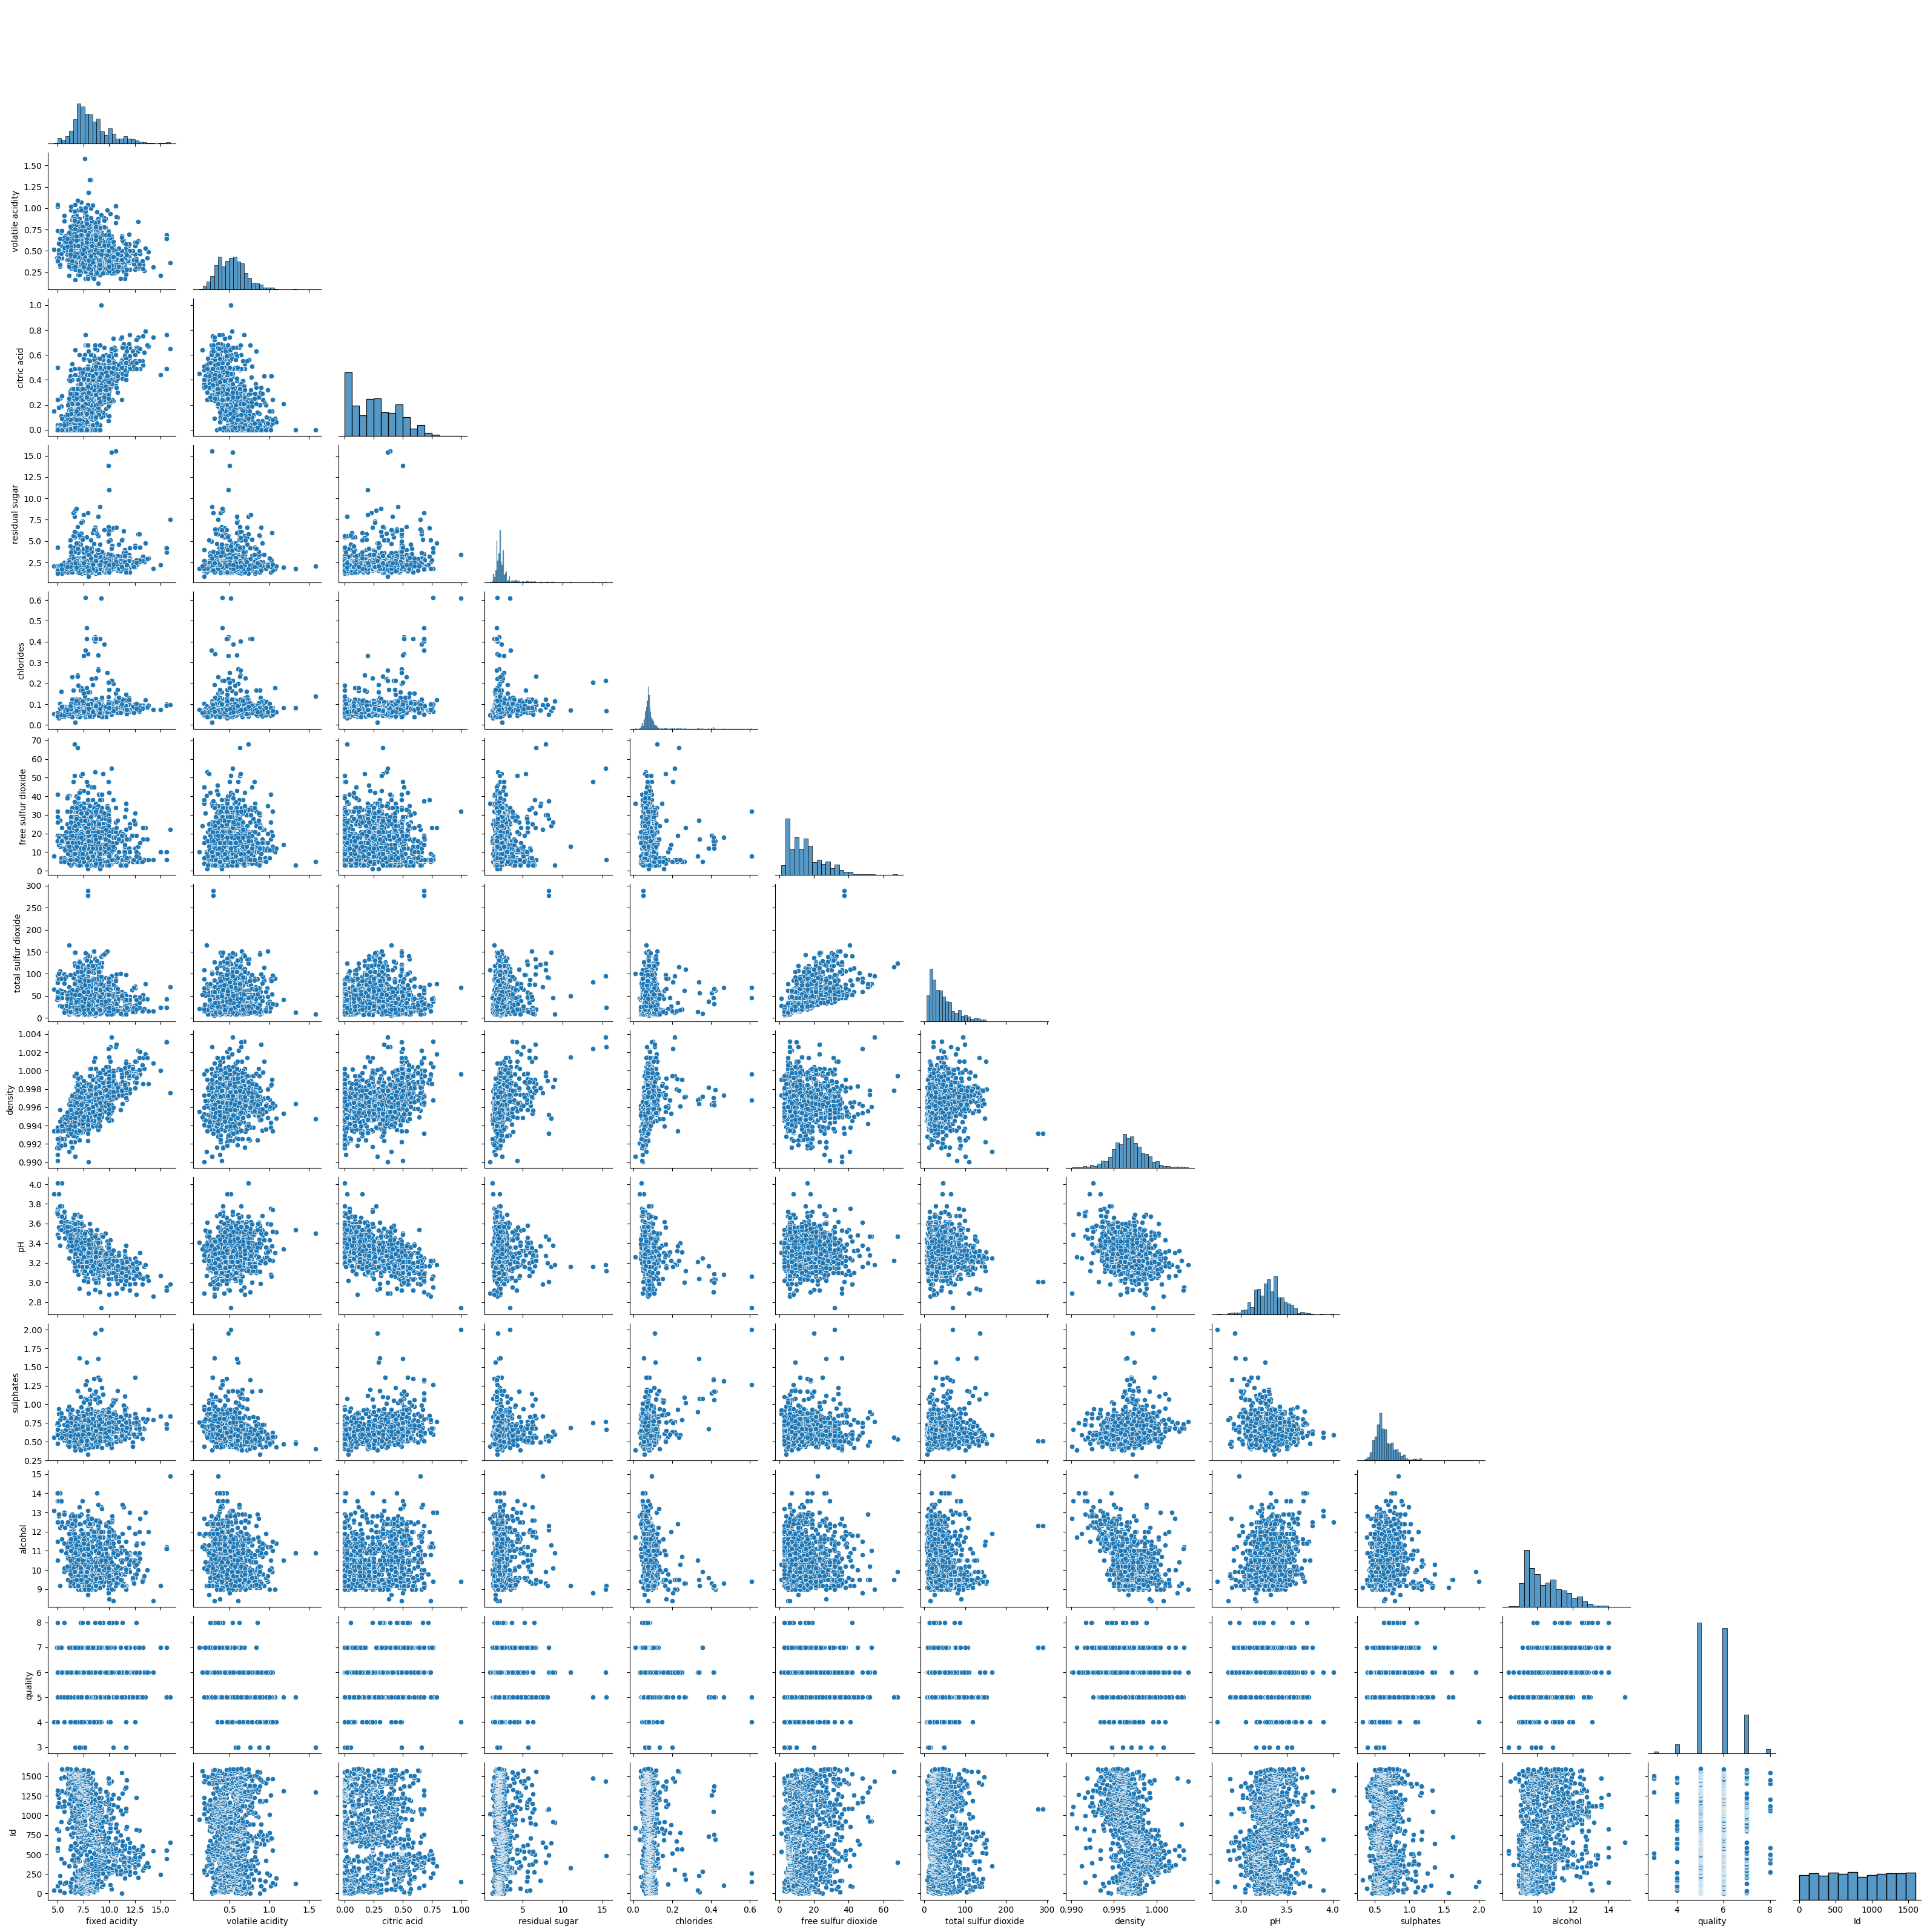

In [28]:
sns.pairplot(data=df, corner=True)

In [26]:
top_5_features = df.corr()['quality'].sort_values(ascending=False).iloc[:5].index.tolist()

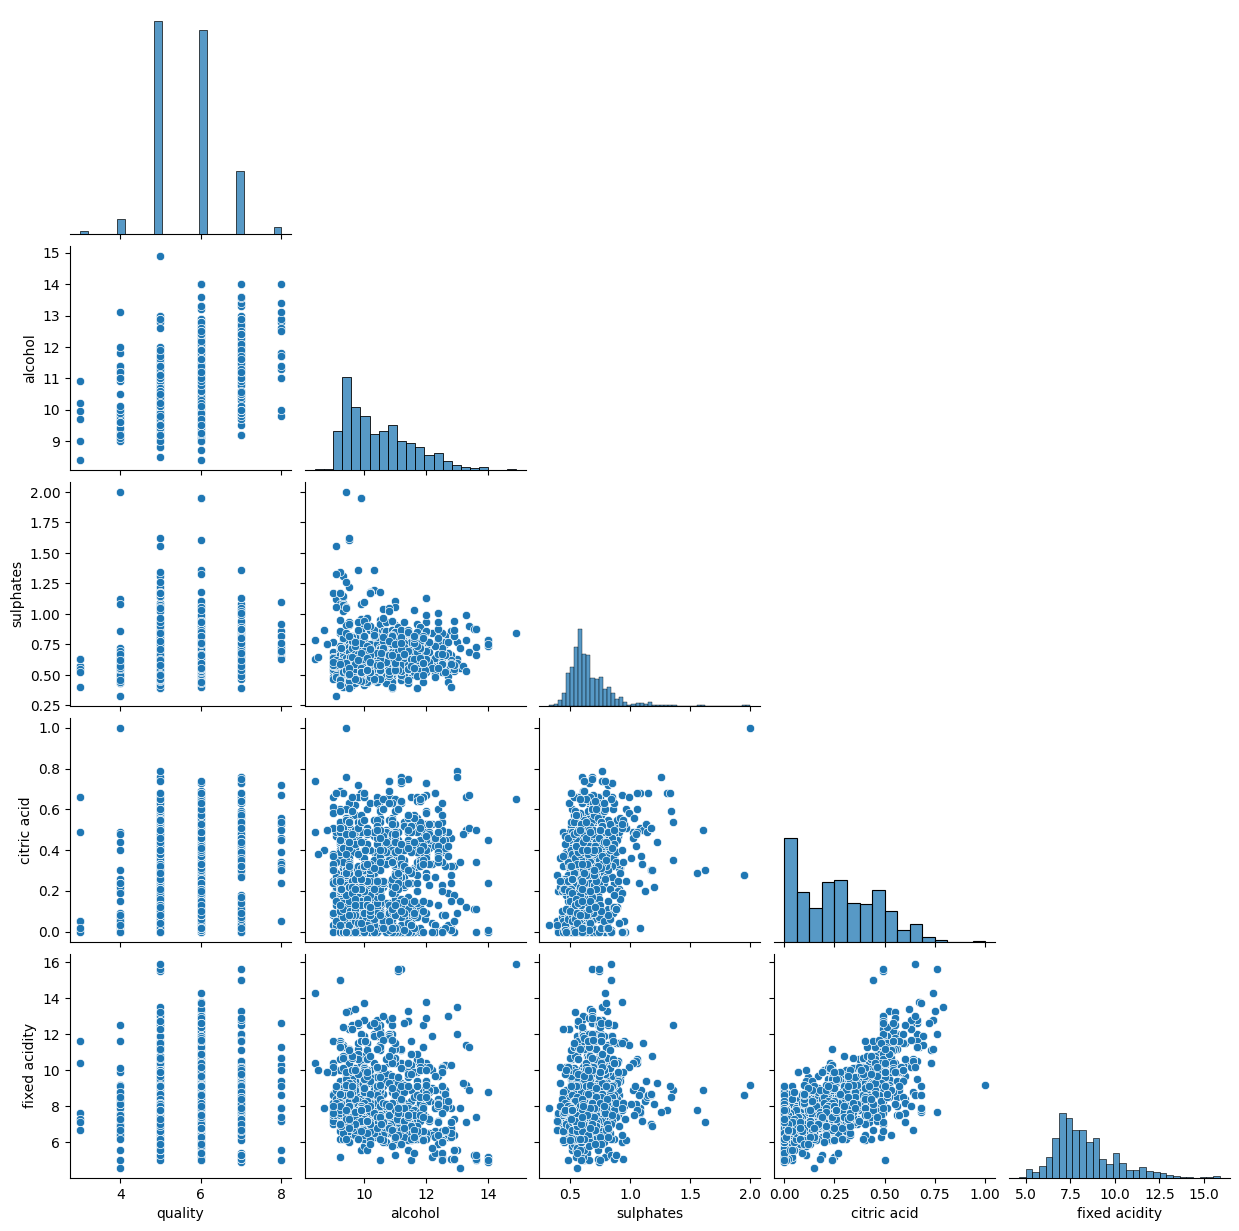

In [27]:
sns.pairplot(data=df[top_5_features], corner=True)

In [91]:
x = df.drop(['quality', "Id"], axis=1).copy()
y = df['quality'].copy()
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

# Train

3 models:
- Linear regression
- LightGBM
- Multi-layer perceptron (simple neural network)

In [110]:
def evaluate(y_true, y_pred, model_name=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'''MAE:\t{mae}\nRMSE:\t{rmse}''')
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.plot(*2*[np.arange(min(y_true),max(y_true)+1)], color='r', ls='--')
    plt.xlabel('y true')
    plt.ylabel('y pred')
    if model_name:
        plt.title(model_name)
    plt.show()

### Simple linear regression

In [111]:
linear_regression = LinearRegression()

In [112]:
linear_regression.fit(x_train, y_train)

LinearRegression()

In [113]:
y_pred = linear_regression.predict(x_valid)

MAE:	0.4773398352588605
RMSE:	0.6164677203737239


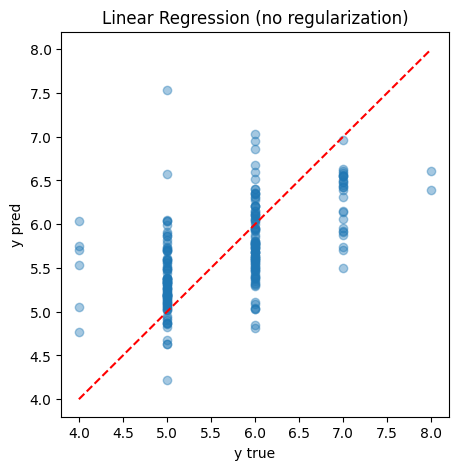

In [114]:
evaluate(y_true=y_valid, y_pred=y_pred, model_name="Linear Regression (no regularization)")

### Regularized linear regression

In [115]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling is important for ElasticNet
    ('elasticnet', ElasticNet(max_iter=10000, random_state=42))
])

In [116]:
# 3. Define the hyperparameter grid to search
param_grid = {
    'elasticnet__alpha': np.logspace(-4, 1, 10),  # Regularization strength
    'elasticnet__l1_ratio': np.linspace(0.1, 0.9, 9),  # Mix ratio between L1 and L2 penalties
    'elasticnet__tol': [1e-4, 1e-5],  # Tolerance for stopping criteria
}

In [117]:
# 4. Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [118]:
# 5. Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('elasticnet',
                                        ElasticNet(max_iter=10000,
                                                   random_state=42))]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                         'elasticnet__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'elasticnet__tol': [0.0001, 1e-05]},
             scoring='neg_mean_squared_error', verbose=1)

In [171]:
grid_search.best_params_

{'elasticnet__alpha': np.float64(0.016681005372000592),
 'elasticnet__l1_ratio': np.float64(0.1),
 'elasticnet__tol': 0.0001}

In [121]:
# 7. Evaluate the best model on the test set
regularized_linear_regression = grid_search.best_estimator_

MAE:	0.4766201085253133
RMSE:	0.6138191914774159


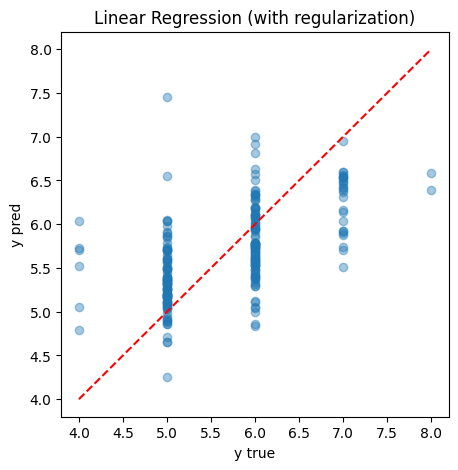

In [122]:
evaluate(
    y_true=y_valid,
    y_pred=regularized_linear_regression.predict(x_valid),
    model_name="Linear Regression (with regularization)",
)

### LGBM

In [172]:
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 7, -1],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0],  # Subset of rows to select on each new iteration
    'colsample_bytree': [0.8, 1.0],  # Subset of features to select on each new iteration
    "reg_alpha": [0, 0.3, 0.9],
    "reg_lambda": [0, 0.3, 0.9],
    "n_jobs": [6],
    "early_stopping_rounds": [1, 10, 50, 100],  # rule of thumb is to have it at 10% of your num_iterations
}

In [173]:
random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1,  # Use all available cores for the search itself
)

In [174]:
%%capture
random_search.fit(
    x_train, 
    y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_names=['train', 'valid'],
    eval_metric='rmse',
)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [175]:
random_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.3,
 'reg_alpha': 0,
 'num_leaves': 63,
 'n_jobs': 6,
 'n_estimators': 500,
 'min_child_samples': 20,
 'max_depth': -1,
 'learning_rate': 0.01,
 'early_stopping_rounds': 10,
 'colsample_bytree': 0.8}

In [176]:
lgbm_model = random_search.best_estimator_

/Users/pavloseimskyi/Desktop/github-repos/ml-workshop/.venv/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

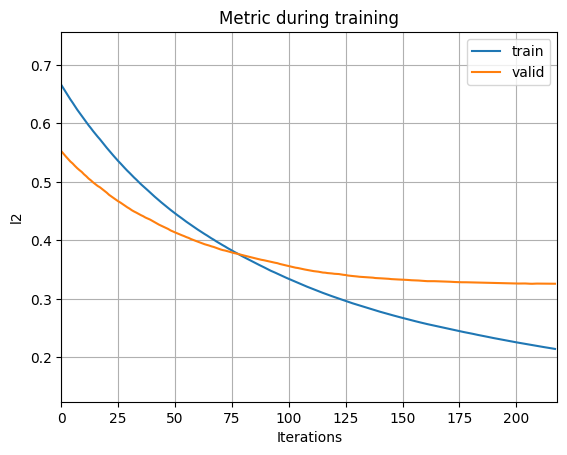

In [177]:
lgb.plot_metric(lgbm_model)

MAE:	0.4514243979589853
RMSE:	0.5707830502018423


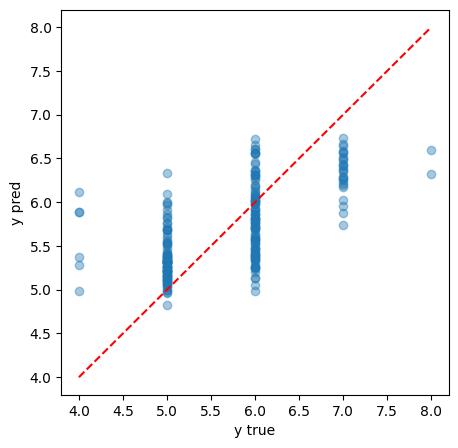

In [178]:
evaluate(y_valid, lgbm_model.predict(x_valid))

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

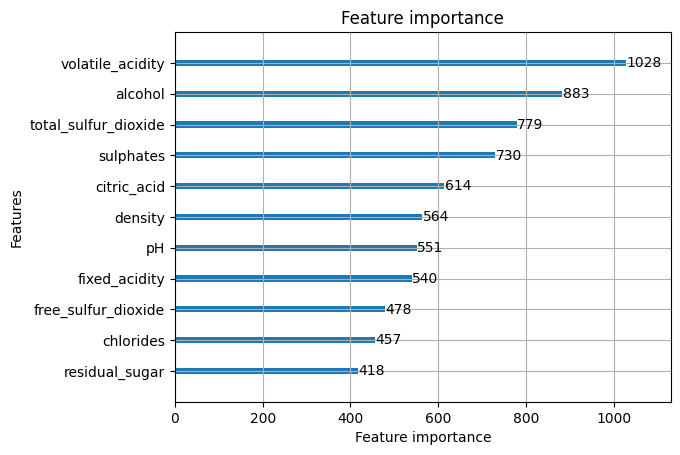

In [179]:
lgb.plot_importance(lgbm_model)

---